# Clustering Consulting Project 

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

# Start

First thing is starting a new spark session. Let's call it hacker:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('hacker').getOrCreate()

Next is reading the data, which is in a csv file:

In [2]:
df = spark.read.csv('input data/hack_data.csv', header=True, inferSchema=True)

df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



Let's check the top rows and their information:

In [3]:
for s in df.head(3):
    print(s)
    print('-------')
    print('\n')

Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)
-------


Row(Session_Connection_Time=20.0, Bytes Transferred=720.99, Kali_Trace_Used=0, Servers_Corrupted=3.04, Pages_Corrupted=9.0, Location='British Virgin Islands', WPM_Typing_Speed=69.08)
-------


Row(Session_Connection_Time=31.0, Bytes Transferred=356.32, Kali_Trace_Used=1, Servers_Corrupted=3.71, Pages_Corrupted=8.0, Location='Tokelau', WPM_Typing_Speed=70.58)
-------




All the columns except Location are numerical. Furthermore, it is said in the introduction that the Location feature is most probably useless as the hackers used VPNs.

Let's print all the columns to use in the VectorAssembler:

In [4]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

As explained above, the Location columns will be left out of the inputCols vector. As this is an unsupervised task there is no label column.

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(inputCols=['Session_Connection_Time',
                                 'Bytes Transferred',
                                 'Kali_Trace_Used',
                                 'Servers_Corrupted',
                                 'Pages_Corrupted',
                                 'WPM_Typing_Speed'],
                                  outputCol='features')
output = assembler.transform(df)

After transforming the data, it is a good idea to scale it. To do this the StandardScaler is used:

In [6]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

scaler_model = scaler.fit(output)

cluster_output = scaler_model.transform(output)

In the following cell one can check the new scaled_features vector:

In [7]:
cluster_output.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)



The goal is to check if there were 2 or 3 hackers performing the attacks. Two K-Means models will be created (one with k=2 and teh other with k=3):

In [8]:
from pyspark.ml.clustering import KMeans

kmeans_2 = KMeans(featuresCol='scaled_features', k=2)
kmeans_3 = KMeans(featuresCol='scaled_features', k=3)

Now they are fit to the data:

In [9]:
k2_model = kmeans_2.fit(cluster_output)
k3_model = kmeans_3.fit(cluster_output)

In the introduction it is said that the hackers, whether they were 2 or 3, performed roughly the same amount of attacks. This information will help identifying how many hackers are responsible for the attacks.

Grouping by prediction values and making a count will give the number of attacks performed by each hacker. The results of this for each model can be compared below:

In [10]:
k2_model.transform(cluster_output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [11]:
k3_model.transform(cluster_output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   84|
|         0|   83|
+----------+-----+



Looking at the two cells above it is easy to conclude that there were only two hackers and each of them performed 167 attacks.

Furthermore the Within Set Sum of Squared Errors of both models can be compared:

In [12]:
k2_wssse = k2_model.computeCost(cluster_output)
k3_wssse = k3_model.computeCost(cluster_output)

In [13]:
print('With K = 2')
print('Within Set Sum of Squared Errors = {}'.format(k2_wssse))

With K = 2
Within Set Sum of Squared Errors = 601.7707512676716


In [14]:
print('With K = 3')
print('Within Set Sum of Squared Errors = {}'.format(k3_wssse))

With K = 3
Within Set Sum of Squared Errors = 434.1492898715845


Actually this adds nothing much. It was expected that as K increases, the WSSSE decreases.

If there was no information about being either 2 or 3 hackers the most probable approach would be to calculate the WSSSE for some possible K clusters:

In [15]:
val=[]
ind=[]
for k in range(2,9):
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    model = kmeans.fit(cluster_output)
    wssse = model.computeCost(cluster_output)
    print('With K = {}'.format(k))
    print('Within Set Sum of Squared Errors = {}'.format(wssse))
    print('_ _ _ _ _ _ _ _ _ _')
    ind.append(k)
    val.append(wssse)

With K = 2
Within Set Sum of Squared Errors = 601.7707512676716
_ _ _ _ _ _ _ _ _ _
With K = 3
Within Set Sum of Squared Errors = 434.1492898715845
_ _ _ _ _ _ _ _ _ _
With K = 4
Within Set Sum of Squared Errors = 267.1336116887891
_ _ _ _ _ _ _ _ _ _
With K = 5
Within Set Sum of Squared Errors = 245.36421529748606
_ _ _ _ _ _ _ _ _ _
With K = 6
Within Set Sum of Squared Errors = 227.5888199292027
_ _ _ _ _ _ _ _ _ _
With K = 7
Within Set Sum of Squared Errors = 211.35588411628487
_ _ _ _ _ _ _ _ _ _
With K = 8
Within Set Sum of Squared Errors = 204.52523782698677
_ _ _ _ _ _ _ _ _ _


Known as the elbow method then the number of clusters would be chosen:

Text(0.5, 1.0, 'K-Means Elbow Method')

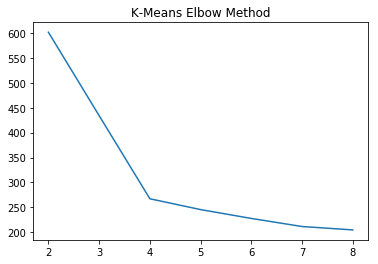

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig = sns.lineplot(x=ind, y=val)

fig.set_title('K-Means Elbow Method')

With this approach 4 clusters would be selected (4 hackers).

Thank you!